In [1]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Pull FRED Data
FRED_KEY = '02b2c2d2bbf883773e270d39679071c9'
FREDurl = 'https://api.stlouisfed.org/fred/series/observations'



param1 = {
    'series_id': 'CES4348100001',
    'api_key': FRED_KEY,
    'file_type': 'json'}

response = requests.get(FREDurl, params=param1)
data = response.json()
observations = data['observations']
df1 = pd.DataFrame(observations)
df1 = df1.rename(columns={"date": "ds","value": "AIREMP"})
df1 = df1[['ds', 'AIREMP']]




param2 = {
    'series_id': 'AIRRPMTSID11',
    'api_key': FRED_KEY,
    'file_type': 'json'}

response = requests.get(FREDurl, params=param2)
data = response.json()
observations = data['observations']
df2 = pd.DataFrame(observations)
df2 = df2.rename(columns={"date": "ds","value": "MILES"})
df2 = df2[['ds', 'MILES']]




param4 = {
    'series_id': 'LOADFACTORD11',
    'api_key': FRED_KEY,
    'file_type': 'json'}

response = requests.get(FREDurl, params=param4)
data = response.json()
observations = data['observations']
df7 = pd.DataFrame(observations)
df7 = df7.rename(columns={"date": "ds","value": "LOAD"})
df7 = df7[['ds', 'LOAD']]


# Pull EIA Data
EIA_KEY = 'S5kBDUycUiKkFCG6uxywpfYtq7IzU7AAhOgoUU4y'


# Initialize parameters
Date = "2010-01-01"
End = None
# API endpoints 
# EIA endpoints


url_WTI = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'   
urlPrice = 'https://api.eia.gov/v2/petroleum/pri/spt/data/' 
url = 'https://api.eia.gov/v2/total-energy/data/'
# Parameters


WTI = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[series][0]": "RWTC",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}


JF = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[series][0]": "EER_EPJK_PF4_RGC_DPG",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

SALES = {
    "api_key": EIA_KEY, # API key
    "frequency": "monthly", # Frequency of data
    "data[0]": "value",  
    "facets[msn][0]": "JFACPUS",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

response = requests.get(urlPrice, params=JF)
data = response.json()
df5 = pd.DataFrame(data['response']['data'])
df5 = df5[['period', 'value']]
df5.rename(columns={'value': 'Jet Fuel'}, inplace=True)
df5.rename(columns={'period': 'ds'}, inplace=True)

response2 = requests.get(url_WTI, params=WTI)
data2 = response2.json()
df6 = pd.DataFrame(data2['response']['data'])
df6 = df6[['period', 'value']]
df6.rename(columns={'value': 'WTI'}, inplace=True)
df6.rename(columns={'period': 'ds'}, inplace=True)

response2 = requests.get(url, params=SALES)
data2 = response2.json()
df8 = pd.DataFrame(data2['response']['data'])
df8 = df8[['period', 'value']]
df8.rename(columns={'value': 'SALES'}, inplace=True)
df8.rename(columns={'period': 'ds'}, inplace=True)


for df in [df1, df2, df6, df7, df5, df8]:
    df['ds'] = pd.to_datetime(df['ds']).dt.to_period('M').dt.to_timestamp()
df_merged = df6
df_merged = pd.merge(df_merged, df5, on='ds', how='outer')
df_merged = pd.merge(df_merged, df1, on='ds', how='outer')
df_merged = pd.merge(df_merged, df2, on='ds', how='outer')
df_merged = pd.merge(df_merged, df7, on='ds', how='outer')
df_merged = pd.merge(df_merged, df8, on='ds', how='outer')
df_merged['month_num'] = df_merged['ds'].dt.month
df_merged['MILES'] = pd.to_numeric(df_merged['MILES'], errors='coerce')
df_merged['MILES'] = df_merged['MILES'] / 1000

print(df_merged.tail(20))

df_merged.to_pickle("JetFuel.pkl")

            ds    WTI Jet Fuel AIREMP      MILES  LOAD     SALES  month_num
406 2023-11-01  77.69    2.734  560.0  92316.729  83.8  1623.478         11
407 2023-12-01   71.9    2.387  562.2  92659.342  83.5  1668.197         12
408 2024-01-01  74.15    2.585  560.9  92311.746  83.7    1536.2          1
409 2024-02-01  77.25    2.683  563.5  93529.008  83.4  1563.982          2
410 2024-03-01  81.28    2.593  562.5  93911.900  82.7  1650.865          3
411 2024-04-01  85.35    2.605  563.5  93755.820  82.2  1708.474          4
412 2024-05-01  80.02     2.38  565.2  94359.916  82.1  1768.152          5
413 2024-06-01  79.77    2.394  566.0  96308.686  83.7  1710.171          6
414 2024-07-01   81.8    2.419  564.8  95135.481  82.8   1831.68          7
415 2024-08-01  76.68    2.176  566.0  94843.182  83.9  1788.855          8
416 2024-09-01  70.24    1.982  564.9  94138.547  83.9  1670.613          9
417 2024-10-01  71.99    2.068  563.6  93805.288  83.5  1729.743         10
418 2024-11-

In [3]:
# Approximate current month pricing data
df = pd.read_pickle("JetFuel.pkl")
df['ds'] = pd.to_datetime(df['ds'])


# Pull EIA Data
EIA_KEY = 'S5kBDUycUiKkFCG6uxywpfYtq7IzU7AAhOgoUU4y'

urlPrice = 'https://api.eia.gov/v2/petroleum/pri/spt/data/' 
# Initialize parameters
Date = "2025-01-01"
End = None
# API endpoints 


JF = {
    "api_key": EIA_KEY, # API key
    "frequency": "daily", # Frequency of data
    "data[0]": "value",  
    "facets[series][0]": "EER_EPJK_PF4_RGC_DPG",  # Series ID
    "start": Date , # Start date
    "end": End, # End date
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 500
}

response = requests.get(urlPrice, params=JF)
data = response.json()
dfdaily = pd.DataFrame(data['response']['data'])
dfdaily = dfdaily[['period', 'value']]
dfdaily.rename(columns={'value': 'Jet Fuel'}, inplace=True)
dfdaily.rename(columns={'period': 'ds'}, inplace=True)



# Filter last 30 days and compute average
# Ensure 'date' is datetime
dfdaily['date'] = pd.to_datetime(dfdaily['ds'])
dfdaily['Jet Fuel'] = pd.to_numeric(dfdaily['Jet Fuel'], errors='coerce')

# Filter past 30 days
today = datetime.today()
start_date = today - timedelta(days=30)
last_month_data = dfdaily[dfdaily['date'] >= start_date]

# Compute average gas price
JF_avg = last_month_data['Jet Fuel'].mean()


# === Step 1: Get current month start ===
last_reported_month = df['ds'].max()
next_month_start = last_reported_month + relativedelta(months=1)




# === Step 2: Check if row exists for current month ===
if next_month_start not in df['ds'].values:
    
    # === Step 3: Get 30-day average prices from yfinance ===
    today = datetime.today()
    start_date = today - timedelta(days=30)

    wti = yf.download("CL=F", start=start_date, end=today)['Close'].dropna()
    wti_avg = wti.mean().item()

    # === Step 4: Create new row ===
    new_row = {
        'ds': next_month_start,
        'WTI': wti_avg,
        'Jet Fuel': JF_avg,
        # Fill other columns with NaN
        'AIREMP': None,
        'MILES': None,
        'LOAD': None,
        'SALES': None,
    }

    # === Step 5: Append to DataFrame ===
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df['month_num'] = df['ds'].dt.month



df.to_pickle("JetFuel1.pkl")

print(df.tail(20))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

            ds        WTI  Jet Fuel AIREMP      MILES  LOAD     SALES  \
407 2023-12-01       71.9     2.387  562.2  92659.342  83.5  1668.197   
408 2024-01-01      74.15     2.585  560.9  92311.746  83.7    1536.2   
409 2024-02-01      77.25     2.683  563.5  93529.008  83.4  1563.982   
410 2024-03-01      81.28     2.593  562.5  93911.900  82.7  1650.865   
411 2024-04-01      85.35     2.605  563.5  93755.820  82.2  1708.474   
412 2024-05-01      80.02      2.38  565.2  94359.916  82.1  1768.152   
413 2024-06-01      79.77     2.394  566.0  96308.686  83.7  1710.171   
414 2024-07-01       81.8     2.419  564.8  95135.481  82.8   1831.68   
415 2024-08-01      76.68     2.176  566.0  94843.182  83.9  1788.855   
416 2024-09-01      70.24     1.982  564.9  94138.547  83.9  1670.613   
417 2024-10-01      71.99     2.068  563.6  93805.288  83.5  1729.743   
418 2024-11-01      69.95     2.065  565.5  94810.700  85.4  1670.359   
419 2024-12-01      70.12     2.097  569.3  95757.8


/var/folders/1v/qxw436v577vd4tnnpxrghrpw0000gn/T/ipykernel_63897/245125174.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


In [ ]:
# === 1. SET PARAMETERS ===
TARGET_COL = 'MILES'
EXOG_COLS = ['WTI', 'Jet Fuel']
df = pd.read_pickle("JetFuel1.pkl")  # Replace with your actual input file
df = df[df['ds'] >= pd.to_datetime('2021-01-01')].reset_index(drop=True)

# === 2. CLEAN DATA ===
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
for col in EXOG_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('ds').reset_index(drop=True)

# === 3. FEATURE ENGINEERING ===
df['month_num'] = df['ds'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

for lag in [1, 2, 3, 6]:
    df[f'{TARGET_COL}_lag{lag}'] = df[TARGET_COL].shift(lag)
    for col in EXOG_COLS:
        df[f'{col.replace(" ", "")}_lag{lag}'] = df[col].shift(lag)

df[f'{TARGET_COL}_roll3'] = df[TARGET_COL].rolling(window=3).mean().shift(1)
for col in EXOG_COLS:
    df[f'{col.replace(" ", "")}_roll3'] = df[col].rolling(window=3).mean().shift(1)

# === 4. DEFINE FEATURES & TARGET ===
features = (
    EXOG_COLS +
    ['month_num', 'month_sin', 'month_cos'] +
    [f'{TARGET_COL}_lag{l}' for l in [1,2,3,6]] +
    [f'{TARGET_COL}_roll3'] +
    [f'{col.replace(" ", "")}_lag1' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_lag2' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_roll3' for col in EXOG_COLS]
)

df_hist = df.dropna(subset=[TARGET_COL] + features).copy()
X_train = df_hist[features].apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(df_hist[TARGET_COL], errors='coerce')

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# === 5. TRUE HOLD-OUT BACKTEST (80% train, 20% test) ===
df_backtest = df_hist.loc[valid_idx].copy()
X_all = df_backtest[features]
y_all = df_backtest[TARGET_COL]

split_index = int(len(X_all) * 0.8)
X_train_split, X_test = X_all.iloc[:split_index], X_all.iloc[split_index:]
y_train_split, y_test = y_all.iloc[:split_index], y_all.iloc[split_index:]

model = XGBRegressor(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42
)
model.fit(X_train_split, y_train_split, verbose=False)

y_pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== Hold-Out Backtest Error Metrics ===")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")

# === 6. RE-TRAIN ON ALL DATA BEFORE FORECASTING ===
model.fit(X_train, y_train, verbose=False)

# === 7. FORECAST MISSING TARGET VALUES ===
missing_idxs = df.index[df[TARGET_COL].isna()]

for i in missing_idxs:
    prior = df.loc[:i - 1].copy()
    last = prior.iloc[-1]

    new_feats = {
        'month_num': df.at[i, 'ds'].month,
        'month_sin': np.sin(2 * np.pi * df.at[i, 'ds'].month / 12),
        'month_cos': np.cos(2 * np.pi * df.at[i, 'ds'].month / 12),
        f'{TARGET_COL}_lag1': last[TARGET_COL],
        f'{TARGET_COL}_lag2': last[f'{TARGET_COL}_lag1'],
        f'{TARGET_COL}_lag3': last[f'{TARGET_COL}_lag2'],
        f'{TARGET_COL}_lag6': prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else last[TARGET_COL],
        f'{TARGET_COL}_roll3': pd.to_numeric(prior[TARGET_COL].iloc[-3:], errors='coerce').mean(),
    }

    for col in EXOG_COLS:
        new_feats[col] = df.at[i, col]
        new_feats[f'{col.replace(" ", "")}_lag1'] = last[col]
        new_feats[f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        new_feats[f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

    input_df = pd.DataFrame([new_feats])
    input_df = input_df.reindex(columns=features).apply(pd.to_numeric, errors='coerce')
    y_pred = model.predict(input_df)[0]

    df.loc[i, TARGET_COL] = y_pred
    df.loc[i, f'{TARGET_COL}_lag1'] = y_pred
    df.loc[i, f'{TARGET_COL}_lag2'] = last[f'{TARGET_COL}_lag1']
    df.loc[i, f'{TARGET_COL}_lag3'] = last[f'{TARGET_COL}_lag2']
    df.loc[i, f'{TARGET_COL}_lag6'] = prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else y_pred

    roll_vals = pd.concat([prior[TARGET_COL].iloc[-2:], pd.Series([y_pred])])
    df.loc[i, f'{TARGET_COL}_roll3'] = roll_vals.mean() if len(roll_vals) == 3 else y_pred

    for col in EXOG_COLS:
        df.loc[i, f'{col.replace(" ", "")}_lag1'] = last[col]
        df.loc[i, f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        df.loc[i, f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

# === 8. FINAL OUTPUT ===
df = df[['ds', TARGET_COL]].copy()
print("\n=== Final df with historical + forecasted values ===")
print(df.tail(8).to_string(index=False))

df_full = df

#=============================#
#    Optimize Parameters      #
#=============================#

"""from sklearn.model_selection import GridSearchCV

# === 5A. HYPERPARAMETER TUNING ===
# === HYPERPARAMETER SEARCH ONLY ===
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [1, 0.8, 0.6],
    'colsample_bytree': [1, 0.8, 0.6]
}

grid_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n=== Best Parameters Found ===")
print(grid_search.best_params_)"""


=== Hold-Out Backtest Error Metrics ===
MAE  (Mean Absolute Error):      705.31
RMSE (Root Mean Squared Error): 815.45
MAPE (Mean Absolute % Error):   0.75%

=== Final df with historical + forecasted values ===
        ds        MILES
2024-12-01 95757.867000
2025-01-01 93917.641000
2025-02-01 93279.946000
2025-03-01 94682.597000
2025-04-01 94620.028000
2025-05-01 94183.085938
2025-06-01 94346.687500
2025-07-01 94530.492188

=== Best Parameters Found ===
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 600, 'subsample': 1}


In [ ]:
# === 1. SET PARAMETERS ===
TARGET_COL = 'AIREMP'
EXOG_COLS = ['WTI', 'Jet Fuel']
df = pd.read_pickle("JetFuel1.pkl")  # Replace with your actual input file
df = df[df['ds'] >= pd.to_datetime('2021-01-01')].reset_index(drop=True)

# === 2. CLEAN DATA ===
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
for col in EXOG_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('ds').reset_index(drop=True)

# === 3. FEATURE ENGINEERING ===
df['month_num'] = df['ds'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

for lag in [1, 2, 3, 6]:
    df[f'{TARGET_COL}_lag{lag}'] = df[TARGET_COL].shift(lag)
    for col in EXOG_COLS:
        df[f'{col.replace(" ", "")}_lag{lag}'] = df[col].shift(lag)

df[f'{TARGET_COL}_roll3'] = df[TARGET_COL].rolling(window=3).mean().shift(1)
for col in EXOG_COLS:
    df[f'{col.replace(" ", "")}_roll3'] = df[col].rolling(window=3).mean().shift(1)

# === 4. DEFINE FEATURES & TARGET ===
features = (
    EXOG_COLS +
    ['month_num', 'month_sin', 'month_cos'] +
    [f'{TARGET_COL}_lag{l}' for l in [1,2,3,6]] +
    [f'{TARGET_COL}_roll3'] +
    [f'{col.replace(" ", "")}_lag1' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_lag2' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_roll3' for col in EXOG_COLS]
)

df_hist = df.dropna(subset=[TARGET_COL] + features).copy()
X_train = df_hist[features].apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(df_hist[TARGET_COL], errors='coerce')

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# === 5. TRUE HOLD-OUT BACKTEST (80% train, 20% test) ===
df_backtest = df_hist.loc[valid_idx].copy()
X_all = df_backtest[features]
y_all = df_backtest[TARGET_COL]

split_index = int(len(X_all) * 0.8)
X_train_split, X_test = X_all.iloc[:split_index], X_all.iloc[split_index:]
y_train_split, y_test = y_all.iloc[:split_index], y_all.iloc[split_index:]

model = XGBRegressor(
    n_estimators=600,
    max_depth=2,
    learning_rate=0.1,
    subsample=1,
    colsample_bytree=0.6,
    random_state=42
)
model.fit(X_train_split, y_train_split, verbose=False)

y_pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== Hold-Out Backtest Error Metrics ===")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")

# === 6. RE-TRAIN ON ALL DATA BEFORE FORECASTING ===
model.fit(X_train, y_train, verbose=False)

# === 7. FORECAST MISSING TARGET VALUES ===
missing_idxs = df.index[df[TARGET_COL].isna()]

for i in missing_idxs:
    prior = df.loc[:i - 1].copy()
    last = prior.iloc[-1]

    new_feats = {
        'month_num': df.at[i, 'ds'].month,
        'month_sin': np.sin(2 * np.pi * df.at[i, 'ds'].month / 12),
        'month_cos': np.cos(2 * np.pi * df.at[i, 'ds'].month / 12),
        f'{TARGET_COL}_lag1': last[TARGET_COL],
        f'{TARGET_COL}_lag2': last[f'{TARGET_COL}_lag1'],
        f'{TARGET_COL}_lag3': last[f'{TARGET_COL}_lag2'],
        f'{TARGET_COL}_lag6': prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else last[TARGET_COL],
        f'{TARGET_COL}_roll3': pd.to_numeric(prior[TARGET_COL].iloc[-3:], errors='coerce').mean(),
    }

    for col in EXOG_COLS:
        new_feats[col] = df.at[i, col]
        new_feats[f'{col.replace(" ", "")}_lag1'] = last[col]
        new_feats[f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        new_feats[f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

    input_df = pd.DataFrame([new_feats])
    input_df = input_df.reindex(columns=features).apply(pd.to_numeric, errors='coerce')
    y_pred = model.predict(input_df)[0]

    df.loc[i, TARGET_COL] = y_pred
    df.loc[i, f'{TARGET_COL}_lag1'] = y_pred
    df.loc[i, f'{TARGET_COL}_lag2'] = last[f'{TARGET_COL}_lag1']
    df.loc[i, f'{TARGET_COL}_lag3'] = last[f'{TARGET_COL}_lag2']
    df.loc[i, f'{TARGET_COL}_lag6'] = prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else y_pred

    roll_vals = pd.concat([prior[TARGET_COL].iloc[-2:], pd.Series([y_pred])])
    df.loc[i, f'{TARGET_COL}_roll3'] = roll_vals.mean() if len(roll_vals) == 3 else y_pred

    for col in EXOG_COLS:
        df.loc[i, f'{col.replace(" ", "")}_lag1'] = last[col]
        df.loc[i, f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        df.loc[i, f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

# === 8. FINAL OUTPUT ===
df = df[['ds', TARGET_COL]].copy()
print("\n=== Final df with historical + forecasted values ===")
print(df.tail(8).to_string(index=False))

if TARGET_COL not in df_full.columns:
    df_full = pd.merge(df_full, df, on='ds', how='outer')
else:
    df_full.set_index('ds', inplace=True)
    df.set_index('ds', inplace=True)
    df_full.update(df[[TARGET_COL]])
    df_full.reset_index(inplace=True)

#=============================#
#    Optimize Parameters      #
#=============================#

"""from sklearn.model_selection import GridSearchCV

# === 5A. HYPERPARAMETER TUNING ===
# === HYPERPARAMETER SEARCH ONLY ===
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [1, 0.8, 0.6],
    'colsample_bytree': [1, 0.8, 0.6]
}

grid_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n=== Best Parameters Found ===")
print(grid_search.best_params_)"""


=== Hold-Out Backtest Error Metrics ===
MAE  (Mean Absolute Error):      6.99
RMSE (Root Mean Squared Error): 8.80
MAPE (Mean Absolute % Error):   1.21%

=== Final df with historical + forecasted values ===
        ds     AIREMP
2024-12-01 569.300000
2025-01-01 571.000000
2025-02-01 574.600000
2025-03-01 575.000000
2025-04-01 577.900000
2025-05-01 580.300000
2025-06-01 575.900000
2025-07-01 576.041077

=== Best Parameters Found ===
{'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100, 'subsample': 1}


In [ ]:
# === 1. SET PARAMETERS ===
TARGET_COL = 'LOAD'
EXOG_COLS = ['WTI', 'Jet Fuel']
df = pd.read_pickle("JetFuel1.pkl")  # Replace with your actual input file
df = df[df['ds'] >= pd.to_datetime('2015-01-01')].reset_index(drop=True)

# === 2. CLEAN DATA ===
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
for col in EXOG_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('ds').reset_index(drop=True)

# === 3. FEATURE ENGINEERING ===
df['month_num'] = df['ds'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

for lag in [1, 2, 3, 6]:
    df[f'{TARGET_COL}_lag{lag}'] = df[TARGET_COL].shift(lag)
    for col in EXOG_COLS:
        df[f'{col.replace(" ", "")}_lag{lag}'] = df[col].shift(lag)

df[f'{TARGET_COL}_roll3'] = df[TARGET_COL].rolling(window=3).mean().shift(1)
for col in EXOG_COLS:
    df[f'{col.replace(" ", "")}_roll3'] = df[col].rolling(window=3).mean().shift(1)

# === 4. DEFINE FEATURES & TARGET ===
features = (
    EXOG_COLS +
    ['month_num', 'month_sin', 'month_cos'] +
    [f'{TARGET_COL}_lag{l}' for l in [1,2,3,6]] +
    [f'{TARGET_COL}_roll3'] +
    [f'{col.replace(" ", "")}_lag1' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_lag2' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_roll3' for col in EXOG_COLS]
)

df_hist = df.dropna(subset=[TARGET_COL] + features).copy()
X_train = df_hist[features].apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(df_hist[TARGET_COL], errors='coerce')

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# === 5. TRUE HOLD-OUT BACKTEST (80% train, 20% test) ===
df_backtest = df_hist.loc[valid_idx].copy()
X_all = df_backtest[features]
y_all = df_backtest[TARGET_COL]

split_index = int(len(X_all) * 0.8)
X_train_split, X_test = X_all.iloc[:split_index], X_all.iloc[split_index:]
y_train_split, y_test = y_all.iloc[:split_index], y_all.iloc[split_index:]

model = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.6,
    colsample_bytree=1,
    random_state=42
)
model.fit(X_train_split, y_train_split, verbose=False)

y_pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== Hold-Out Backtest Error Metrics ===")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")

# === 6. RE-TRAIN ON ALL DATA BEFORE FORECASTING ===
model.fit(X_train, y_train, verbose=False)

# === 7. FORECAST MISSING TARGET VALUES ===
missing_idxs = df.index[df[TARGET_COL].isna()]

for i in missing_idxs:
    prior = df.loc[:i - 1].copy()
    last = prior.iloc[-1]

    new_feats = {
        'month_num': df.at[i, 'ds'].month,
        'month_sin': np.sin(2 * np.pi * df.at[i, 'ds'].month / 12),
        'month_cos': np.cos(2 * np.pi * df.at[i, 'ds'].month / 12),
        f'{TARGET_COL}_lag1': last[TARGET_COL],
        f'{TARGET_COL}_lag2': last[f'{TARGET_COL}_lag1'],
        f'{TARGET_COL}_lag3': last[f'{TARGET_COL}_lag2'],
        f'{TARGET_COL}_lag6': prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else last[TARGET_COL],
        f'{TARGET_COL}_roll3': pd.to_numeric(prior[TARGET_COL].iloc[-3:], errors='coerce').mean(),
    }

    for col in EXOG_COLS:
        new_feats[col] = df.at[i, col]
        new_feats[f'{col.replace(" ", "")}_lag1'] = last[col]
        new_feats[f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        new_feats[f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

    input_df = pd.DataFrame([new_feats])
    input_df = input_df.reindex(columns=features).apply(pd.to_numeric, errors='coerce')
    y_pred = model.predict(input_df)[0]

    df.loc[i, TARGET_COL] = y_pred
    df.loc[i, f'{TARGET_COL}_lag1'] = y_pred
    df.loc[i, f'{TARGET_COL}_lag2'] = last[f'{TARGET_COL}_lag1']
    df.loc[i, f'{TARGET_COL}_lag3'] = last[f'{TARGET_COL}_lag2']
    df.loc[i, f'{TARGET_COL}_lag6'] = prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else y_pred

    roll_vals = pd.concat([prior[TARGET_COL].iloc[-2:], pd.Series([y_pred])])
    df.loc[i, f'{TARGET_COL}_roll3'] = roll_vals.mean() if len(roll_vals) == 3 else y_pred

    for col in EXOG_COLS:
        df.loc[i, f'{col.replace(" ", "")}_lag1'] = last[col]
        df.loc[i, f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        df.loc[i, f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

# === 8. FINAL OUTPUT ===
df = df[['ds', TARGET_COL]].copy()
print("\n=== Final df with historical + forecasted values ===")
print(df.tail(8).to_string(index=False))


if TARGET_COL not in df_full.columns:
    df_full = pd.merge(df_full, df, on='ds', how='outer')
else:
    df_full.set_index('ds', inplace=True)
    df.set_index('ds', inplace=True)
    df_full.update(df[[TARGET_COL]])
    df_full.reset_index(inplace=True)

#=============================#
#    Optimize Parameters      #
#=============================#

"""from sklearn.model_selection import GridSearchCV

# === 5A. HYPERPARAMETER TUNING ===
# === HYPERPARAMETER SEARCH ONLY ===
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [1, 0.8, 0.6],
    'colsample_bytree': [1, 0.8, 0.6]
}

grid_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n=== Best Parameters Found ===")
print(grid_search.best_params_)"""


=== Hold-Out Backtest Error Metrics ===
MAE  (Mean Absolute Error):      0.83
RMSE (Root Mean Squared Error): 1.05
MAPE (Mean Absolute % Error):   1.00%

=== Final df with historical + forecasted values ===
        ds      LOAD
2024-12-01 84.400000
2025-01-01 83.200000
2025-02-01 82.400000
2025-03-01 81.400000
2025-04-01 78.043495
2025-05-01 77.960617
2025-06-01 78.229126
2025-07-01 77.736000

=== Best Parameters Found ===
{'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 600, 'subsample': 0.6}


In [7]:
df = pd.read_pickle("JetFuel1.pkl")
df = df[['ds', 'SALES']].copy()

if 'SALES' not in df_full.columns:
    df_full = pd.merge(df_full, df, on='ds', how='outer')
else:
    df_full.set_index('ds', inplace=True)
    df.set_index('ds', inplace=True)
    df_full.update(df[['SALES']])
    df_full.reset_index(inplace=True)

df_full = df_full[['ds', 'MILES', 'LOAD', 'AIREMP', 'SALES']].copy()


# Check if last row (excluding 'ds') is all NaN
if not df_full.iloc[-1].drop(labels='ds').isna().all():
    next_date = df_full['ds'].max() + relativedelta(months=1)
    new_row = {col: pd.NA for col in df_full.columns}
    new_row['ds'] = next_date
    df_full = pd.concat([df_full, pd.DataFrame([new_row])], ignore_index=True)

print(df_full.tail())

            ds         MILES       LOAD      AIREMP     SALES
423 2025-04-01  94620.028000  78.043495  577.900000  1852.633
424 2025-05-01  94183.085938  77.960617  580.300000       NaN
425 2025-06-01  94346.687500  78.229126  575.900000       NaN
426 2025-07-01  94530.492188  77.736000  576.041077      None
427 2025-08-01           NaN        NaN         NaN       NaN


/var/folders/1v/qxw436v577vd4tnnpxrghrpw0000gn/T/ipykernel_63897/3387596818.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([df_full, pd.DataFrame([new_row])], ignore_index=True)



=== Hold-Out Backtest Error Metrics ===
MAE  (Mean Absolute Error):      63.97
RMSE (Root Mean Squared Error): 80.25
MAPE (Mean Absolute % Error):   3.65%


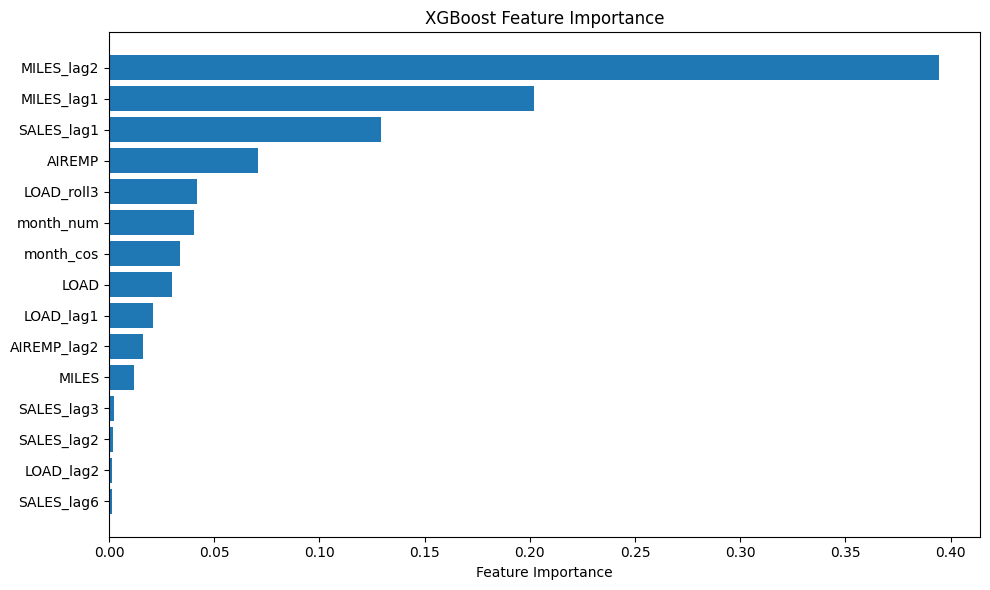


=== Final df with historical + forecasted values ===
        ds       SALES
2025-01-01 1620.217000
2025-02-01 1538.648000
2025-03-01 1636.551000
2025-04-01 1852.633000
2025-05-01 1752.854004
2025-06-01 1772.505981
2025-07-01 1763.519409
2025-08-01 1754.831055

=== Best Parameters Found ===
{'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 800, 'subsample': 1}


: 

In [ ]:
# === 1. SET PARAMETERS ===
TARGET_COL = 'SALES'
EXOG_COLS = ['MILES', 'LOAD', 'AIREMP']
df = df_full  # Replace with your actual input file
df = df[df['ds'] >= pd.to_datetime('2015-01-01')].reset_index(drop=True)

# === 2. CLEAN DATA ===
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
for col in EXOG_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('ds').reset_index(drop=True)

# === 3. FEATURE ENGINEERING ===
df['month_num'] = df['ds'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

for lag in [1, 2, 3, 6]:
    df[f'{TARGET_COL}_lag{lag}'] = df[TARGET_COL].shift(lag)
    for col in EXOG_COLS:
        df[f'{col.replace(" ", "")}_lag{lag}'] = df[col].shift(lag)

df[f'{TARGET_COL}_roll3'] = df[TARGET_COL].rolling(window=3).mean().shift(1)
for col in EXOG_COLS:
    df[f'{col.replace(" ", "")}_roll3'] = df[col].rolling(window=3).mean().shift(1)

# === 4. DEFINE FEATURES & TARGET ===
features = (
    EXOG_COLS +
    ['month_num', 'month_sin', 'month_cos'] +
    [f'{TARGET_COL}_lag{l}' for l in [1,2,3,6]] +
    [f'{TARGET_COL}_roll3'] +
    [f'{col.replace(" ", "")}_lag1' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_lag2' for col in EXOG_COLS] +
    [f'{col.replace(" ", "")}_roll3' for col in EXOG_COLS]
)

df_hist = df.dropna(subset=[TARGET_COL] + features).copy()
X_train = df_hist[features].apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(df_hist[TARGET_COL], errors='coerce')

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# === 5. TRUE HOLD-OUT BACKTEST (80% train, 20% test) ===
df_backtest = df_hist.loc[valid_idx].copy()
X_all = df_backtest[features]
y_all = df_backtest[TARGET_COL]

split_index = int(len(X_all) * 0.8)
X_train_split, X_test = X_all.iloc[:split_index], X_all.iloc[split_index:]
y_train_split, y_test = y_all.iloc[:split_index], y_all.iloc[split_index:]

model = XGBRegressor(
    n_estimators=600,
    max_depth=2,
    learning_rate=0.05,
    subsample=1,
    colsample_bytree=1,
    random_state=42
)
model.fit(X_train_split, y_train_split, verbose=False)

y_pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("\n=== Hold-Out Backtest Error Metrics ===")
print(f"MAE  (Mean Absolute Error):      {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")

# === 6. RE-TRAIN ON ALL DATA BEFORE FORECASTING ===
model.fit(X_train, y_train, verbose=False)

#

importances = model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1]

top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[sorted_idx][:top_n][::-1])
plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx[:top_n]][::-1])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

# === 7. FORECAST MISSING TARGET VALUES ===
missing_idxs = df.index[df[TARGET_COL].isna()]

for i in missing_idxs:
    prior = df.loc[:i - 1].copy()
    last = prior.iloc[-1]

    new_feats = {
        'month_num': df.at[i, 'ds'].month,
        'month_sin': np.sin(2 * np.pi * df.at[i, 'ds'].month / 12),
        'month_cos': np.cos(2 * np.pi * df.at[i, 'ds'].month / 12),
        f'{TARGET_COL}_lag1': last[TARGET_COL],
        f'{TARGET_COL}_lag2': last[f'{TARGET_COL}_lag1'],
        f'{TARGET_COL}_lag3': last[f'{TARGET_COL}_lag2'],
        f'{TARGET_COL}_lag6': prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else last[TARGET_COL],
        f'{TARGET_COL}_roll3': pd.to_numeric(prior[TARGET_COL].iloc[-3:], errors='coerce').mean(),
    }

    for col in EXOG_COLS:
        new_feats[col] = df.at[i, col]
        new_feats[f'{col.replace(" ", "")}_lag1'] = last[col]
        new_feats[f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        new_feats[f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

    input_df = pd.DataFrame([new_feats])
    input_df = input_df.reindex(columns=features).apply(pd.to_numeric, errors='coerce')
    y_pred = model.predict(input_df)[0]

    df.loc[i, TARGET_COL] = y_pred
    df.loc[i, f'{TARGET_COL}_lag1'] = y_pred
    df.loc[i, f'{TARGET_COL}_lag2'] = last[f'{TARGET_COL}_lag1']
    df.loc[i, f'{TARGET_COL}_lag3'] = last[f'{TARGET_COL}_lag2']
    df.loc[i, f'{TARGET_COL}_lag6'] = prior[TARGET_COL].iloc[-6] if len(prior) >= 6 else y_pred

    roll_vals = pd.concat([prior[TARGET_COL].iloc[-2:], pd.Series([y_pred])])
    df.loc[i, f'{TARGET_COL}_roll3'] = roll_vals.mean() if len(roll_vals) == 3 else y_pred

    for col in EXOG_COLS:
        df.loc[i, f'{col.replace(" ", "")}_lag1'] = last[col]
        df.loc[i, f'{col.replace(" ", "")}_lag2'] = last[f'{col.replace(" ", "")}_lag1']
        df.loc[i, f'{col.replace(" ", "")}_roll3'] = pd.to_numeric(prior[col].iloc[-3:], errors='coerce').mean()

# === 8. FINAL OUTPUT ===
df = df[['ds', TARGET_COL]].copy()
df.to_pickle("JetFuelD.pkl")
print("\n=== Final df with historical + forecasted values ===")
print(df.tail(8).to_string(index=False))


#=============================#
#    Optimize Parameters      #
#=============================#

"""from sklearn.model_selection import GridSearchCV

# === 5A. HYPERPARAMETER TUNING ===
# === HYPERPARAMETER SEARCH ONLY ===
param_grid = {
    'n_estimators': [100, 200, 300, 400, 600, 800],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [1, 0.8, 0.6],
    'colsample_bytree': [1, 0.8, 0.6]
}

grid_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=grid_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n=== Best Parameters Found ===")
print(grid_search.best_params_)"""